## Analyzing Extreme Precipitation Events in Bloomington Using Generalized Extreme Value Regression

### *Sets up*

In [55]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import sys
sys.path.append('../G577-homework3/')
import gevfunctions as gevf
import maxlikelihood as max_like

#### Read the 2-day maximum precipitation data for Bloomington

In [56]:
df = pd.read_csv('/home/data/bloomington_rx2day.csv')

In [57]:
df

,#Year,Rx2day [in]
0,1895,2.200787
1,1896,2.677165
2,1897,5.889764
3,1898,2.578740
4,1899,2.610236
...,...,...
122,2018,5.137795
123,2019,3.740157
124,2020,3.578740
125,2021,6.098425


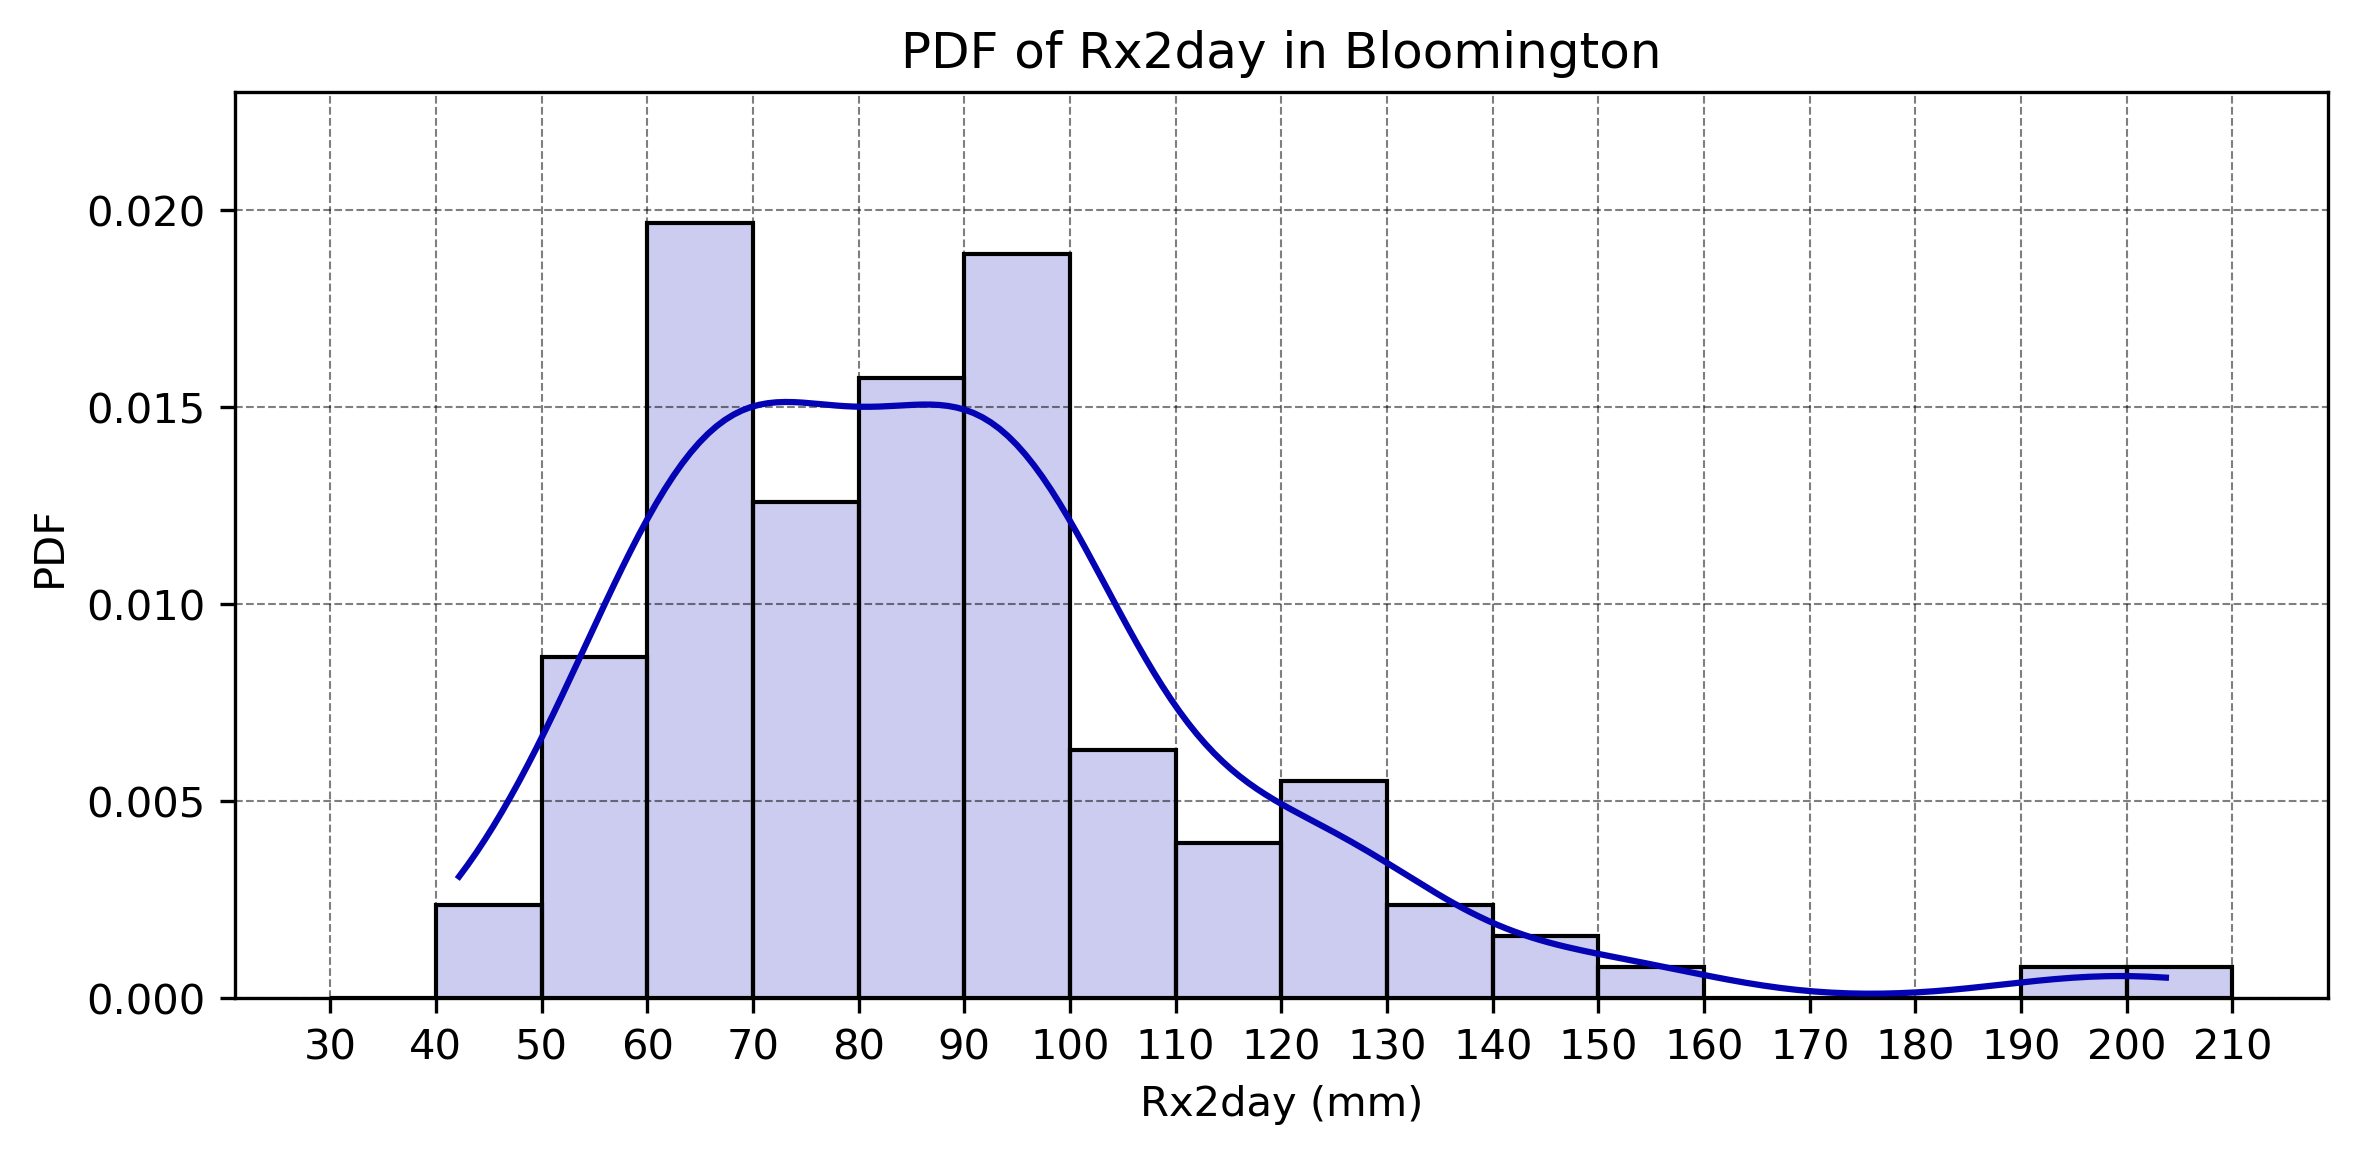

In [58]:
prec = df['Rx2day [in]'].values * 25.4

fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=300)
bins = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]
sns.histplot(prec, kde=True, color='#0404b4', bins=bins, alpha=0.2, stat='density')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5, color='k')
ax.set_title('PDF of Rx2day in Bloomington')
ax.set_xlabel('Rx2day (mm)')
ax.set_ylabel('PDF') 
ax.set_xticks(bins)
ax.set_yticks([0.000, 0.005, 0.010, 0.015, 0.020])
ax.set_ylim(0, 0.023)

plt.show()


#### Use GEV regression to analyze Rx2day precipitation from 1950 to 2022.

In [59]:
time = df['#Year'].values
prec = df['Rx2day [in]'].values * 25.4  # Convert [in] to [mm]

param0 = [3, np.mean(prec), np.std(prec), 0.1]  # [cmu, mu0, sigma, xi] 
bounds = [(-1, 1), (None, None), (1e-3, None), (-0.5, 0.5)]  # bounds for [cmu, mu0, sigma, xi] 

# Run the maximum likelihood estimation
neg_log_lik, param_estimates = max_like.gev_ns_mle(prec[55:], time[55:]-1950, param0, bounds)

In [60]:
# Print the results
print("Negative Log-Likelihood:", neg_log_lik)
print("Fitted GEV Parameters:")
print("cmu =", param_estimates[0])
print("mu0 =", param_estimates[1])
print("sigma =", param_estimates[2])
print("xi =", param_estimates[3])

Negative Log-Likelihood: 327.22544020832015
Fitted GEV Parameters:
cmu = 0.18469282403928777
mu0 = 68.24021171790025
sigma = 20.54593183409143
xi = -0.10217167612141144


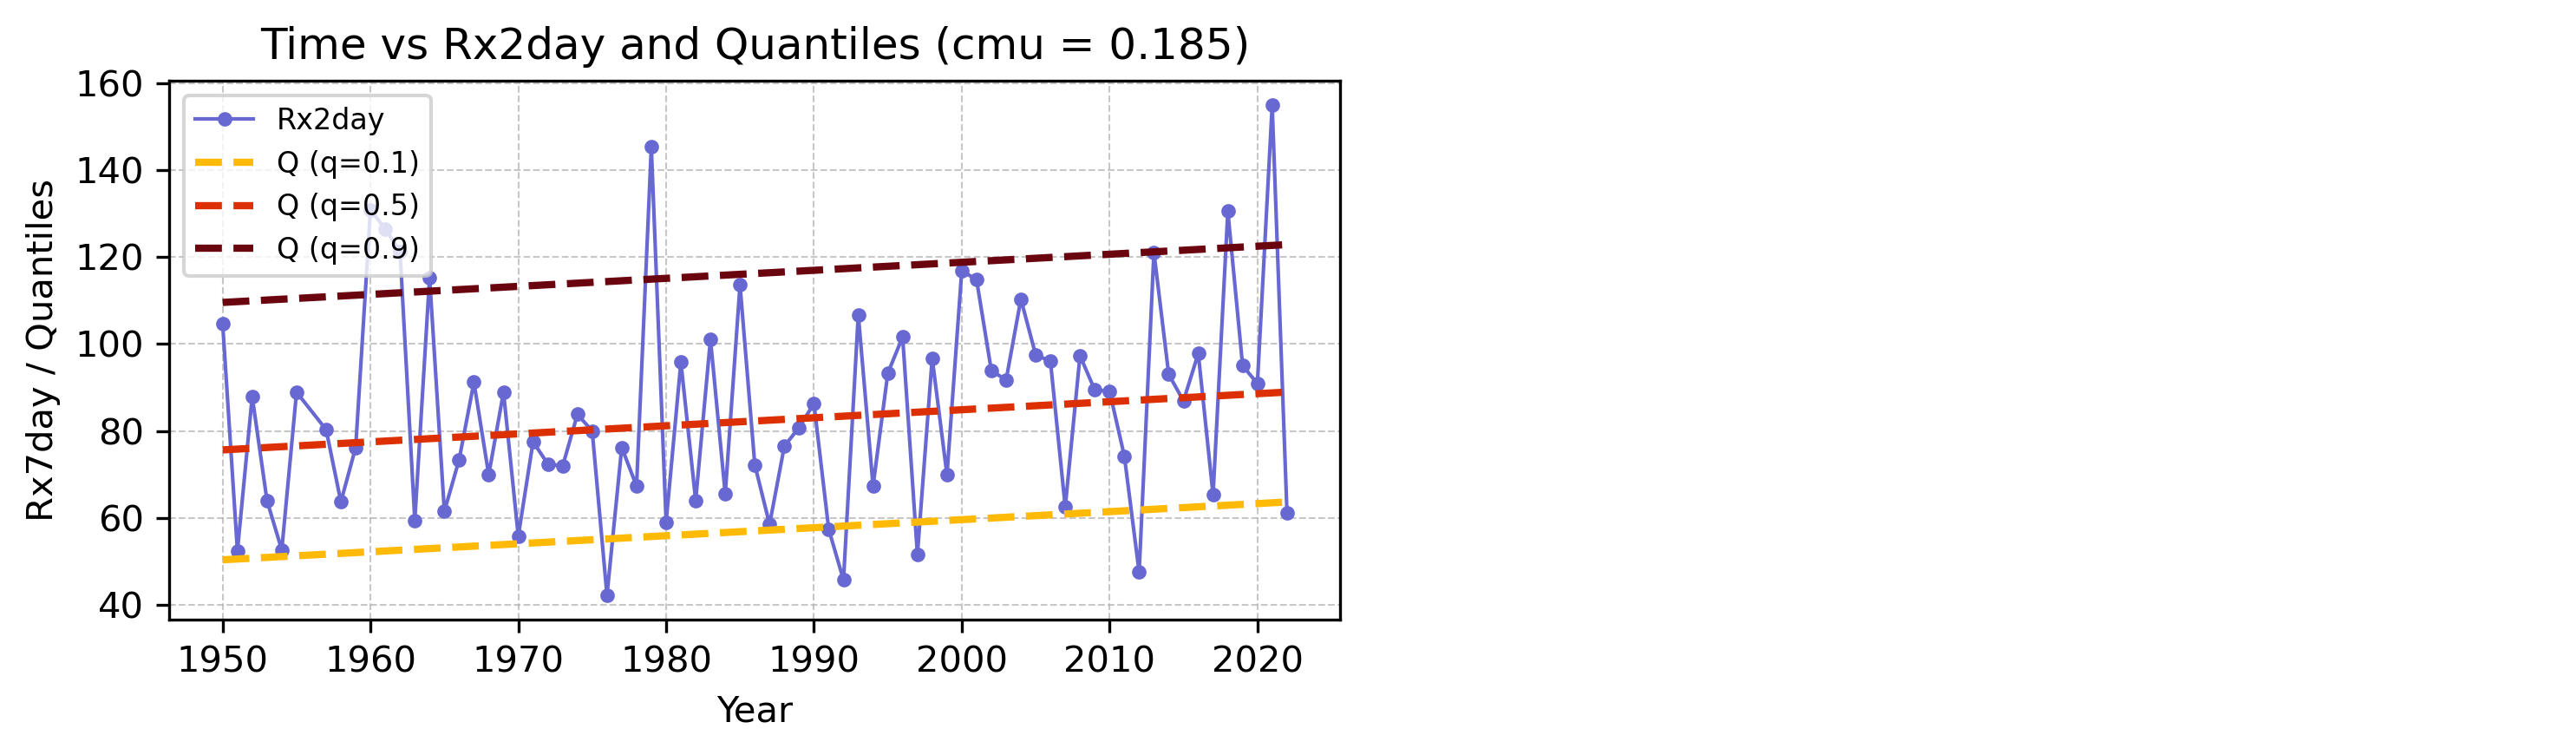

In [65]:
t = time[55:]-1950 
q_values = [0.1, 0.5, 0.9] 

quantiles = {q: gevf.gev_ns_quantile(q, t, param_estimates[0], param_estimates[1], param_estimates[2], param_estimates[3]) for q in q_values} # Calculate quantiles

fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300) 
ax[0].plot(t, prec[55:], label="Rx2day", color='#6868d2', marker='o',ms=3,lw=1, linestyle='-')

colors = ['#ffba08', '#dc2f02', '#6a040f']
for i, q in enumerate(q_values):
    ax[0].plot(t, quantiles[q], label=f"Q (q={q})", color=colors[i],lw=2, linestyle='--')

ax[0].set_title(f"Time vs Rx2day and Quantiles (cmu = {param_estimates[0]:.3f})")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rx7day / Quantiles")
ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax[0].set_xticks(np.arange(0, 75, 10))  
ax[0].set_xticklabels(np.arange(1950, 2025, 10))  
ax[0].legend(loc=2, prop={'size': 8})
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Estimates the return interval of the event in 2021

In [66]:
# Extract parameters
cmu, mu0, sigma, xi = param_estimates

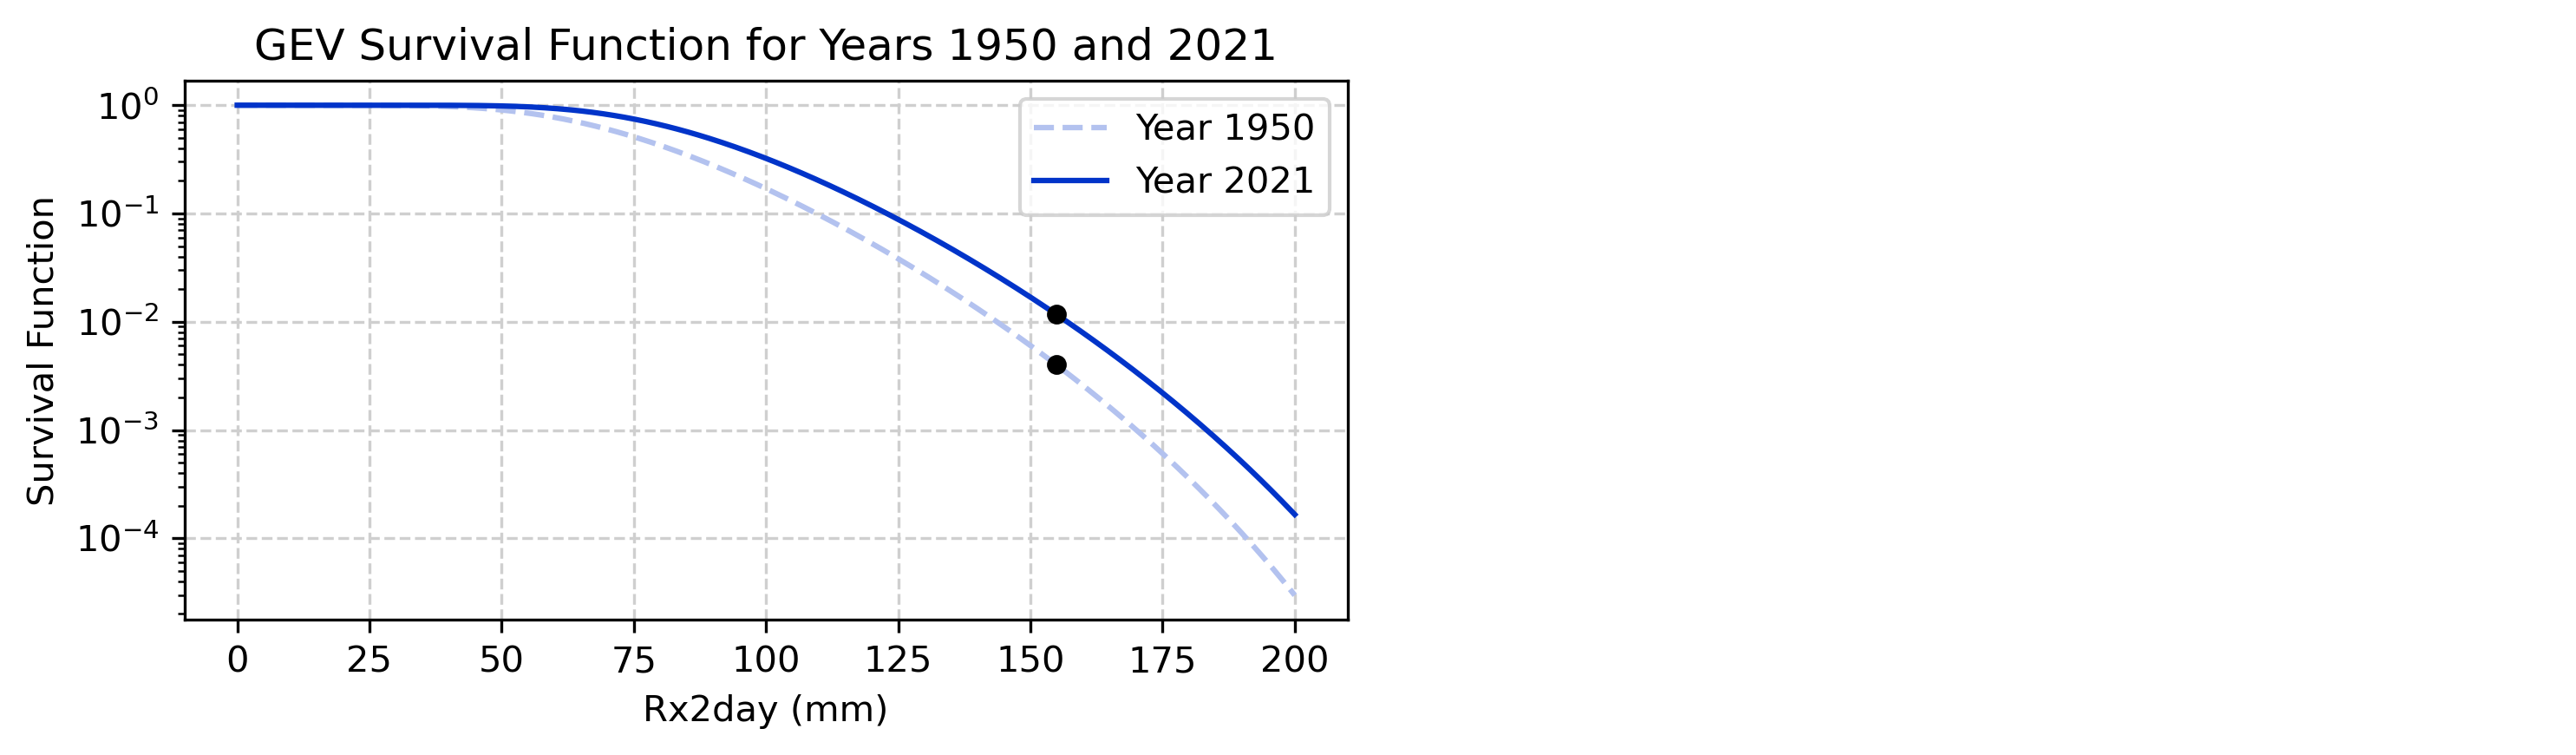

In [67]:
thresholds = np.linspace(0, 200, 400)
cdf_values_2021 = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=72) # Calculate CDF
cdf_values_1950 = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=0)

sf_values_2021 = 1 - cdf_values_2021  # Calculate survival functions
sf_values_1950 = 1 - cdf_values_1950


fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)

ax[0].plot(thresholds, sf_values_1950, color='#b3c2ef', label='Year 1950', ls='--')# Plot survival functions for years 1950 and 2021
ax[0].plot(thresholds, sf_values_2021, color='#0134c9', label='Year 2021')


x_point_1950 = thresholds[309] # Add scatter points at Rx2day = 154.9
x_point_2021 = thresholds[309]
y_point_1950 = sf_values_1950[309]
y_point_2021 = sf_values_2021[309]
ax[0].scatter(x_point_1950, y_point_1950, color='k', s=20, zorder=2)  
ax[0].scatter(x_point_2021, y_point_2021, color='k', s=20, zorder=2) 

ax[0].set_title('GEV Survival Function for Years 1950 and 2021')
ax[0].set_xlabel('Rx2day (mm)')
ax[0].set_ylabel('Survival Function')
ax[0].set_yscale('log')

ax[0].grid(True, which='major', linestyle='--', color='#cfcfcf')
ax[0].legend()
ax[1].axis('off')
plt.tight_layout()
plt.show()


In [68]:
Rx2day = 154.9  # thresholds[309] = 154.88 
return_periods_1950 = 1 / (sf_values_1950[309])
return_periods_2021 = 1 / (sf_values_2021[309])

print(f'Return period for the observed Rx2day from Bloomington extreme precipitation event in 2021: {return_periods_2021:.2f}')
print(f'Return period for the observed Rx2day from Bloomington extreme precipitation event in 1950: {return_periods_1950:.2f}')


Return period for the observed Rx2day from Bloomington extreme precipitation event in 2021: 85.36
Return period for the observed Rx2day from Bloomington extreme precipitation event in 1950: 249.35


#### Estimates the risk ratio of the event in current times versus 1950

In [69]:
risk_ratio = sf_values_2021[309]/sf_values_1950[309]
print(f'The risk ratio of extreme precipitation events occurring in 2021 compared to 1950: {risk_ratio:.2f}')

The risk ratio of extreme precipitation events occurring in 2021 compared to 1950: 2.92


### Appemdix

#### Use GEV regression to analyze Rx2day precipitation from 1895 to 2022.

In [78]:
time = df['#Year'].values
prec = df['Rx2day [in]'].values * 25.4  # Convert [in] to [mm]

param0 = [3, np.mean(prec), np.std(prec), 0.1]  # [cmu, mu0, sigma, xi] 
bounds = [(-1, 1), (None, None), (1e-3, None), (-0.5, 0.5)]  # bounds for [cmu, mu0, sigma, xi] 

# Run the maximum likelihood estimation
neg_log_lik, param_estimates = max_like.gev_ns_mle(prec, time-1895, param0, bounds)

In [79]:
# Print the results
print("Negative Log-Likelihood:", neg_log_lik)
print("Fitted GEV Parameters:")
print("cmu =", param_estimates[0])
print("mu0 =", param_estimates[1])
print("sigma =", param_estimates[2])
print("xi =", param_estimates[3])

Negative Log-Likelihood: 581.8531386944961
Fitted GEV Parameters:
cmu = -0.02292054036977287
mu0 = 76.28307658855636
sigma = 19.65757160819915
xi = 0.04055519783590676


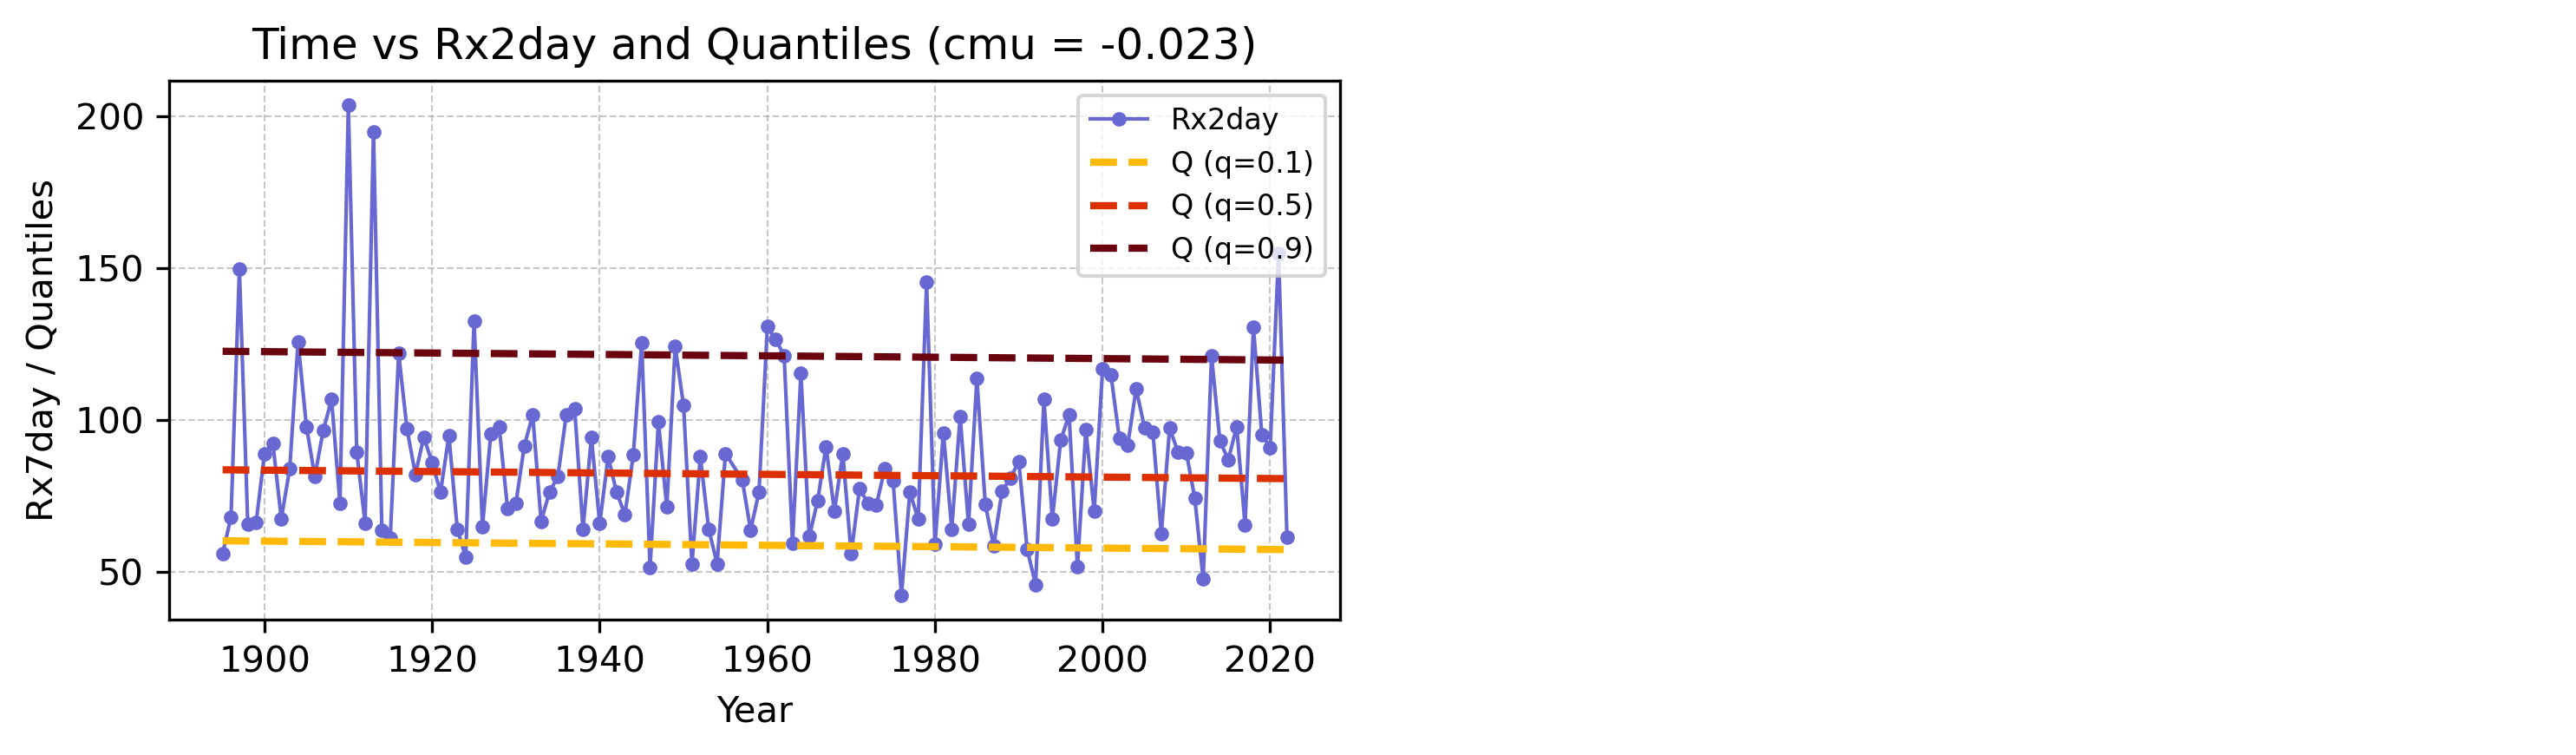

In [80]:
t = time-1895 # Converted to 0-66 years
q_values = [0.1, 0.5, 0.9] 

quantiles = {q: gevf.gev_ns_quantile(q, t, param_estimates[0], param_estimates[1], param_estimates[2], param_estimates[3]) for q in q_values} # Calculate quantiles

fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300) 
ax[0].plot(t, prec, label="Rx2day", color='#6868d2', marker='o',ms=3,lw=1, linestyle='-')

colors = ['#ffba08', '#dc2f02', '#6a040f']
for i, q in enumerate(q_values):
    ax[0].plot(t, quantiles[q], label=f"Q (q={q})", color=colors[i],lw=2, linestyle='--')

ax[0].set_title(f"Time vs Rx2day and Quantiles (cmu = {param_estimates[0]:.3f})")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rx7day / Quantiles")
ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax[0].set_xticks(np.arange(5, 130, 20))  
ax[0].set_xticklabels(np.arange(1900, 2025, 20))  
ax[0].legend(loc=1, prop={'size': 8})
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [81]:
# Extract parameters
cmu, mu0, sigma, xi = param_estimates

In [83]:
t

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

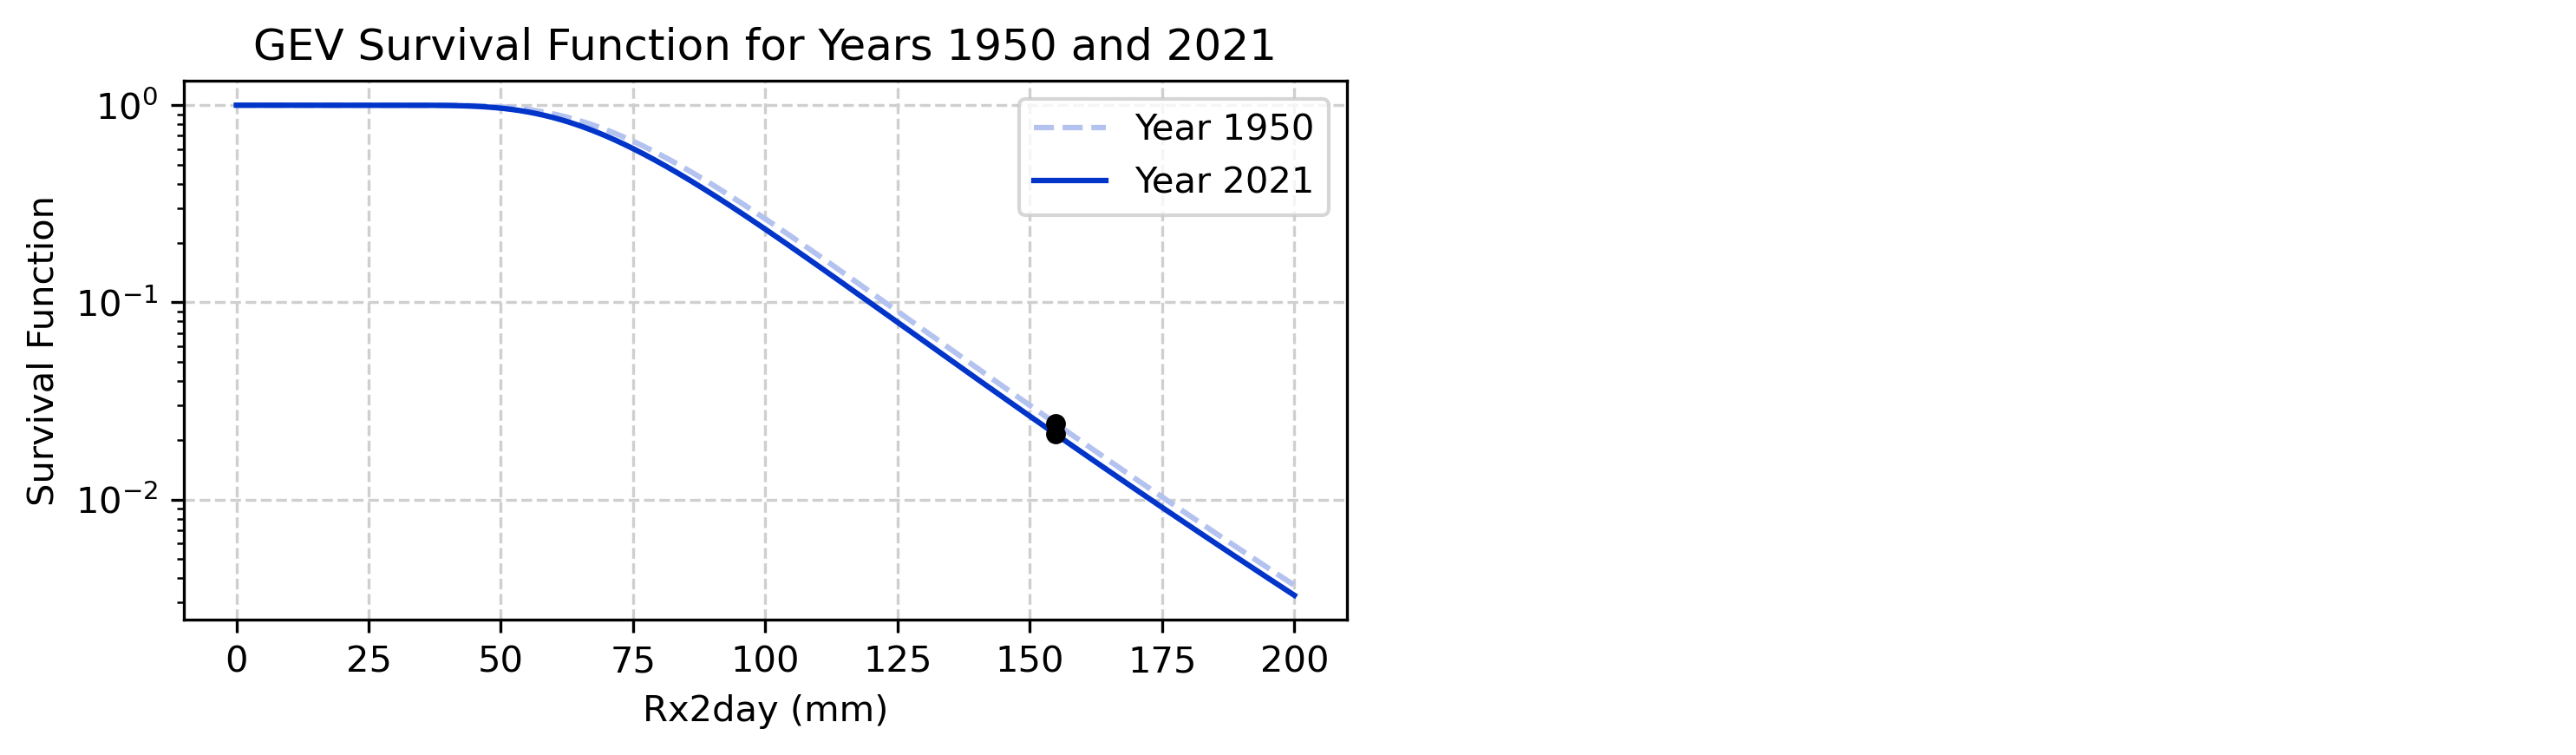

In [85]:
thresholds = np.linspace(0, 200, 400)
cdf_values_2021 = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=126) # Calculate CDF
cdf_values_1950 = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=0)

sf_values_2021 = 1 - cdf_values_2021  # Calculate survival functions
sf_values_1950 = 1 - cdf_values_1950


fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)

ax[0].plot(thresholds, sf_values_1950, color='#b3c2ef', label='Year 1950', ls='--')# Plot survival functions for years 1950 and 2021
ax[0].plot(thresholds, sf_values_2021, color='#0134c9', label='Year 2021')


x_point_1950 = thresholds[309] # Add scatter points at Rx2day = 154.9
x_point_2021 = thresholds[309]
y_point_1950 = sf_values_1950[309]
y_point_2021 = sf_values_2021[309]
ax[0].scatter(x_point_1950, y_point_1950, color='k', s=20, zorder=2)  
ax[0].scatter(x_point_2021, y_point_2021, color='k', s=20, zorder=2) 

ax[0].set_title('GEV Survival Function for Years 1950 and 2021')
ax[0].set_xlabel('Rx2day (mm)')
ax[0].set_ylabel('Survival Function')
ax[0].set_yscale('log')

ax[0].grid(True, which='major', linestyle='--', color='#cfcfcf')
ax[0].legend()
ax[1].axis('off')
plt.tight_layout()
plt.show()



In [86]:
Rx2day = 154.9  # thresholds[309] = 154.88 
return_periods_1950 = 1 / (sf_values_1950[309])
return_periods_2021 = 1 / (sf_values_2021[309])

print(f'Return period for the observed Rx2day from Bloomington extreme precipitation event in 2021: {return_periods_2021:.2f}')
print(f'Return period for the observed Rx2day from Bloomington extreme precipitation event in 1950: {return_periods_1950:.2f}')


Return period for the observed Rx2day from Bloomington extreme precipitation event in 2021: 46.65
Return period for the observed Rx2day from Bloomington extreme precipitation event in 1950: 41.18


In [87]:
risk_ratio = sf_values_2021[309]/sf_values_1950[309]
print(f'The risk ratio of extreme precipitation events occurring in 2021 compared to 1950: {risk_ratio:.2f}')

The risk ratio of extreme precipitation events occurring in 2021 compared to 1950: 0.88
